# 3-4. 막대 그래프 (Bar Chart)

## 3-4-1. 기본적인 막대 그래프

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [2]:
startyear=2000
endyear=2019
lat1=15
lat2=75

In [3]:
def get_var_DJF(varname, latcenter):
    
    minlat = latcenter - 5
    maxlat = latcenter + 5
    minlon = 0
    maxlon = 360
    
    f=Dataset(varname+".mon.mean.nc", "r")
    lat=np.squeeze(f.variables["lat"][:]) #lat 좌표값  
    lon=np.squeeze(f.variables["lon"][:]) #lon 좌표값
    ind_lat = np.logical_and(lat>=minlat, lat<=maxlat) #Boolean 형태의 array
    ind_lon = np.logical_and(lon>=minlon, lon<=maxlon) #Boolean 형태의 array
    nlat, nlon = ind_lat.sum(), ind_lon.sum()
    #print(ind_lat, ind_lon)
    
    time=np.squeeze(f.variables["time"][:])
    #print(time) #datetime64[ns] 형태로 저장되어 있음. 
    #1800년도를 기준으로 몇시간 뒤인지 형태로 저장되어있음..;
    #1297320 = (1948-1800까지의 총 일 수 = 54,055일) *24  hrs
    time=np.array([date(1800,1,1)+timedelta(hours=x) for x in time])
    #그래서 기준이 되는 1800년 1월 1일에 timedelta 를 더해주면 
    #[yyyy-mm-dd] 형태로 날짜가 변환이 될 수 있는 것이지
    #미친거 아님?
    #결론 : 걍 xarray 쓰셈
    print(time[0])
    years=np.array([x.year for x in time])
    #print(time[0].year) #1948 출력
    months=np.array([x.month for x in time])
    
    condition_year = np.logical_and(years>=startyear, years<=endyear)
    condition_month = np.logical_or(months<=2, months ==12)
    
    ind_time=np.logical_and(condition_year, condition_month)
    #print(ind_time)
    
    var=np.squeeze(f.variables[varname][ind_time,ind_lat,ind_lon])
    var=var.reshape(-1)
    #print(var)
    print(np.shape(var))
    
    return(var)

In [4]:
rhum1 = get_var_DJF("rhum", lat1)
rhum2 = get_var_DJF("rhum", lat2)
rhum = np.vstack((rhum1, rhum2)) #2차원 배열 / 행렬로 합치기 column수 같아야함
#자매품 np.hstack raw수 같아야함.
N = np.shape(rhum)[1]
np.shape(rhum)

1948-01-01
(43200,)
1948-01-01
(43200,)


(2, 43200)

In [5]:
bins = np.arange(5, 95+10, 10) #각 구간의 중간값
binedges = np.arange(0, 100+10, 10) # 각 구간의 경계값

freq = np.zeros((2,len(bins)), np.float32) #(2*10) 0으로 가득찬 행렬

for i in range(2):
    freq[i,:] = np.histogram(rhum[i,:], binedges, density = False )[0] /N
    #N = 43200
    #binedges = [0, 10, 20, 30, 40, ..., 90, 100] -> bins = binedges
print(freq[0,:])
print(freq[1,:])

cumfreq = np.cumsum(freq, axis=1)
#axis = 1 | sum over columns for each of the 2 rows #가로줄 -> 방향으로 누적합
#axis = 0 | sum over rows for each of the 43200 columns #세로줄 ↓ 방향으로 누적합.

print(cumfreq[0,:])
print(cumfreq[1,:])

[0.0025463  0.06180555 0.05210648 0.0325     0.0250463  0.03768519
 0.06495371 0.30641204 0.4065509  0.01039352]
[0.00219907 0.00710648 0.01236111 0.02805556 0.04789352 0.08173611
 0.12138889 0.18962963 0.3476852  0.16194445]
[0.0025463  0.06435185 0.11645833 0.14895833 0.17400461 0.2116898
 0.2766435  0.58305556 0.9896065  1.        ]
[0.00219907 0.00930556 0.02166667 0.04972222 0.09761574 0.17935185
 0.30074075 0.4903704  0.8380556  1.        ]


In [6]:
binedges

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

[0.0025463  0.06435185 0.11645833 0.14895833 0.17400463 0.21168981
 0.27664352 0.58305556 0.98960648 1.        ]
[0.00219907 0.00930556 0.02166667 0.04972222 0.09761574 0.17935185
 0.30074074 0.49037037 0.83805556 1.        ]


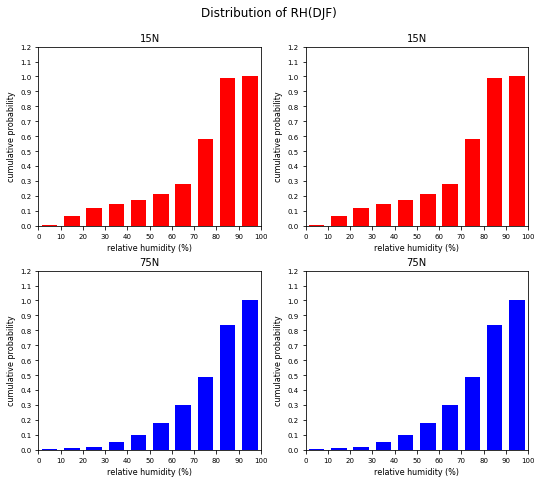

In [7]:
plot_cumulative = True #True일 땐 누적분포, False 일 땐 확률 밀도
fig = plt.figure(figsize=(8,7))
titles = [str(lat1)+"N", str(lat2)+"N"]
colors=["r","b"]
xticks = np.arange(0,100+10,10)

if plot_cumulative: #True면 즉, 누적분포를 그린다고 설정하면
    yticks = np.arange(0,1.1+0.1,0.1)
else: #확률 밀도 함수
    yticks = np.arange(0,0.5+0.1,0.1)
    
for i in range(2):
    for j in range(2):
        fig.add_subplot(2,2,2*i+j+1)
        if j==0:
            histogram = plt.hist(rhum[i,:], xticks, density = True, align="mid", orientation="vertical",
                                rwidth=0.7, color=colors[i], cumulative=plot_cumulative)
            
            print(histogram[0])
            
        else: 
            if plot_cumulative:
                plt.bar(bins, cumfreq[i,:], width = 7, align='center', color=colors[i])
                
            else: 
                plt.bar(bins,freq[i,:], align="center", color=colors[i])
                    
        if plot_cumulative:
            plt.axis((0,100,0,1.2))
        else: 
            plt.axis((0,100,0,0.5))    
                
            
        plt.xlabel("relative humidity (%)", fontsize=8)
        plt.xticks(xticks, label=[str(x) for x in xticks], fontsize=7)
        if j ==0:
            if plot_cumulative:
                plt.ylabel("cumulative probability",fontsize=8)
            else:
                plt.ylabel("probability x 0.1", fontsize=8)
                    
        else:
            if plot_cumulative:
                plt.ylabel("cumulative probability", fontsize=8)
            else:
                plt.ylabel("probability", fontsize=8)
                    
        plt.yticks(yticks, label=[str(y) for y in yticks], fontsize=7)
        plt.title(titles[i], fontsize=10)
            
plt.suptitle("Distribution of RH(DJF)", fontsize=12) #add a centered suptitle to the figure.
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.95, wspace=0.2, hspace=0.25)

plt.show()

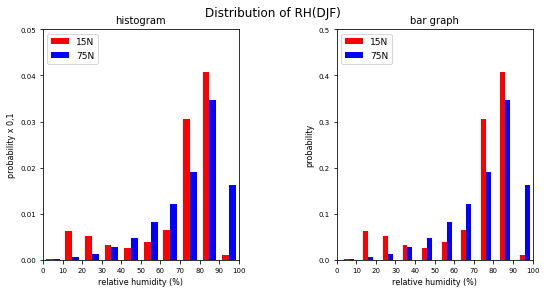

In [21]:
fig = plt.figure(figsize=(8,4))
titles = ["histogram", "bar graph"]
colors = ["r", "b"]
labels = [str(lat1)+'N', str(lat2)+'N']
xticks = np.arange(0,100+10,10)
yticks = np.arange(0,0.5+0.1,0.1)

for i in range(2):
    fig.add_subplot(1,2,i+1)
    
    if i==0:
        plt.hist(rhum.T, xticks, density=True, rwidth=0.7, align="mid", orientation="vertical",
                color=colors, label=labels)
        
        plt.ylabel("probability x 0,1", fontsize=8)
        plt.axis((0,100,0,0.05))
        plt.yticks(yticks/10, label = [str(y) for y in yticks/10], fontsize=7)
        
    else:
        for j in range(2):
            plt.bar(bins+2.5*(j-0.05), freq[j,:], width=2.5, align='center', color=colors[j],
                   label=labels[j])
            
            
        plt.ylabel("probability", fontsize=8)
        plt.axis((0,100,0,0.5))
        plt.yticks(yticks, label=[str(y) for y in yticks], fontsize=7)
        
    plt.legend(loc='upper left', fontsize=9)
    plt.xlabel("relative humidity (%)", fontsize=8)
    plt.xticks(xticks, label=[str(x) for x in xticks], fontsize=7)
    plt.title(titles[i], fontsize=10)
    
    
plt.suptitle("Distribution of RH(DJF)", fontsize=12)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.95, wspace=0.5, hspace=0)

plt.show()

In [18]:
print(bins+2.5*(0-0.05))
print(bins+2.5*(1-0.05))
print(bins)

[ 4.875 14.875 24.875 34.875 44.875 54.875 64.875 74.875 84.875 94.875]
[ 7.375 17.375 27.375 37.375 47.375 57.375 67.375 77.375 87.375 97.375]
[ 5 15 25 35 45 55 65 75 85 95]
